### Import library

In [18]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

### Load data
* 물체의 형상 2D 이미지(X)
* 각 대상 물체의 끌림 항력(drag coefficient) (Y)

In [2]:
## object 2D images
object_2d_imgs = np.load("./data/imgs.npy")

## drag coefficient data
drag_coeff = np.load("./data/labels.npy")

In [3]:
## 총 3000 개의 데이터
## 각 이미지는 (128, 128) pixel size
object_2d_imgs.shape , drag_coeff.shape

((3000, 128, 128, 1), (3000, 1))

#### 물체 형상 이미지 데이터 샘플

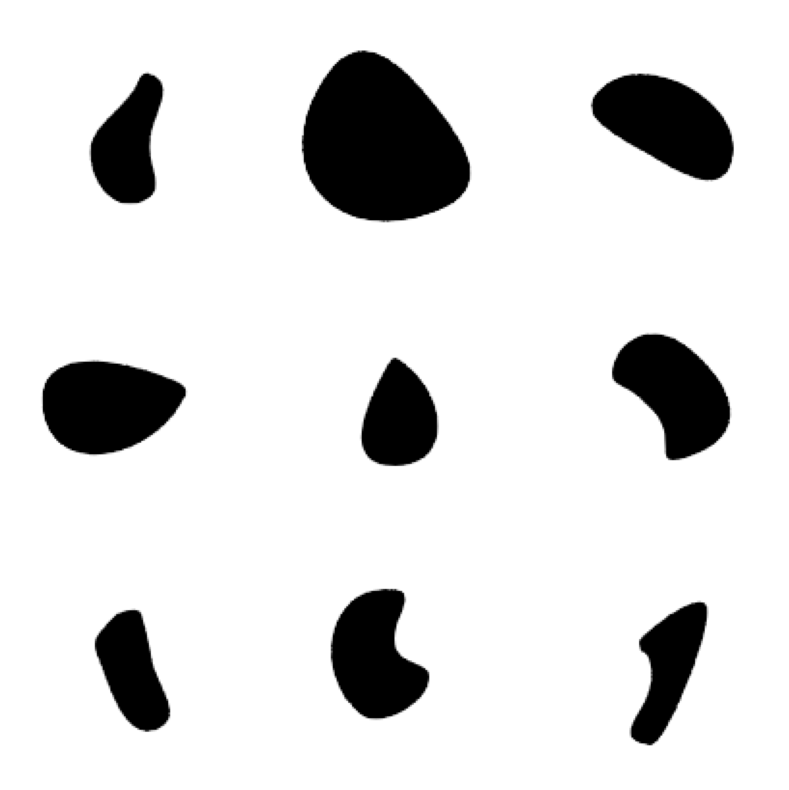

In [4]:
# 1. 9개의 이미지를 선택
num_images = 9
selected_imgs = object_2d_imgs[:num_images, :, :, 0]  # 9개의 이미지 선택 및 마지막 차원 제거

# 2. 3x3 행렬로 이미지 시각화
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(selected_imgs[i], cmap='gray')
    ax.axis('off')  # 축 숨기기

plt.tight_layout()
plt.show()

### 학습 데이터 , 테스트 데이터 분리
* 전체 데이터의 80% 학습 데이터, 20% 테스트 데이터로 사용

In [5]:
test_data_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(object_2d_imgs, drag_coeff, test_size = test_data_ratio, random_state = 42)

In [6]:
X_train.shape , X_test.shape

((2400, 128, 128, 1), (600, 128, 128, 1))

### 뉴럴넷 생성

* CNN + Fully Connected layers
* 회귀 모델임으로 마지막 레이어에서는 activation function 을 적용하지 않음에 유의
* 'Adam' optimizer with default learning rate
* loss : mean squared error

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'SAME', input_shape = (128, 128, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'SAME'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'SAME'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1) ## last layer
])

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

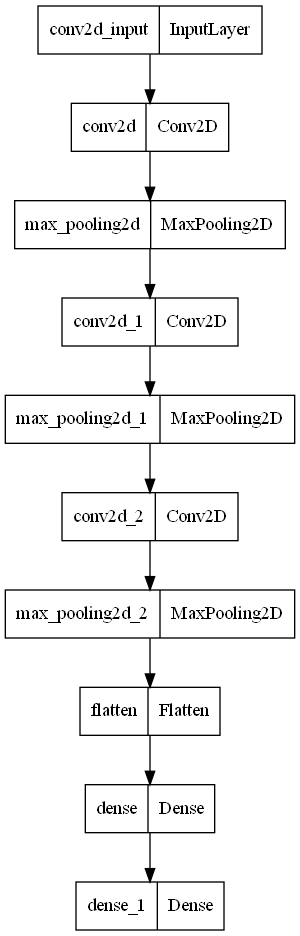

In [9]:
## 생성된 뉴럴넷 구조 시각화

from tensorflow.keras.utils import plot_model
plot_model(model)

In [11]:
## 뉴럴넷 상세 정보
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

### 학습 진행

In [12]:
history = model.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_split = 0.1)

Epoch 1/10
68/68 [==============================] - 5s 21ms/step - loss: 0.9732 - val_loss: 0.0213
Epoch 2/10
68/68 [==============================] - 1s 16ms/step - loss: 0.0111 - val_loss: 0.0070
Epoch 3/10
68/68 [==============================] - 1s 16ms/step - loss: 0.0059 - val_loss: 0.0047
Epoch 4/10
68/68 [==============================] - 1s 16ms/step - loss: 0.0042 - val_loss: 0.0064
Epoch 5/10
68/68 [==============================] - 1s 16ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 6/10
68/68 [==============================] - 1s 16ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 7/10
68/68 [==============================] - 1s 16ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 8/10
68/68 [==============================] - 1s 16ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 9/10
68/68 [==============================] - 1s 16ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 10/10
68/68 [==============================] - 1s 16ms/step - loss: 0.0026 - val_loss: 0.0040


### 학습 결과 검토(학습 손실 곡선)
* 학습이 진행되면서 손실이 줄어듦을 확인할 수 있음

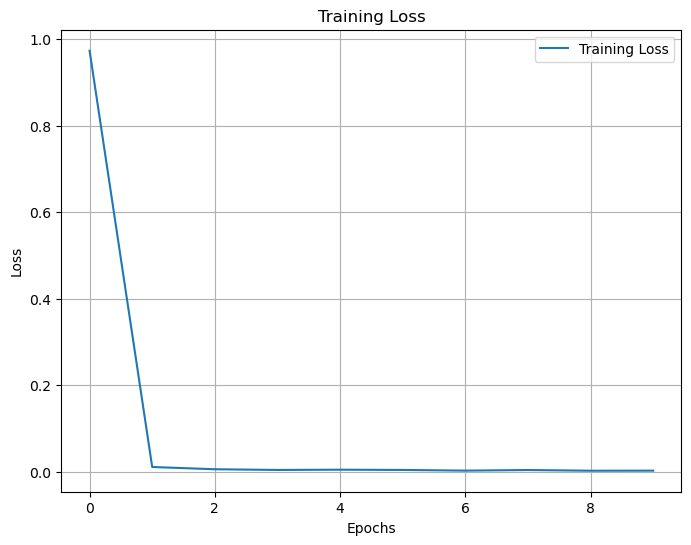

In [14]:
def plot_training_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)  # 그래프에 그리드 추가
    plt.show()

# 정의된 함수를 사용하여 학습 손실 시각화
plot_training_loss(history)

### 모델 예측 성능 평가
* 학습된 모델로 테스트 데이터셋의 이미지들에 대하여 drag coefficient 예측 진행
* 예측된 값과 실제값의 비교
* 비교 지표는 MAE(Mean Absolue Error), MSE(Mean Squared Error), R^2 Score
* 회귀 모델 성능 지표인 R^2 Score = 0.98 수준으로 상당히 우수함

In [25]:
## 테스트 데이터셋 이미지에 대하여 끌링 항력값 예측
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

19/19 [==============================] - 0s 21ms/step
Mean Absolute Error: 0.04908227492745081
Mean Squared Error: 0.0049144735428965965
R^2 Score: 0.9813863515251068


#### 예측 데이터와 실제 데이터 산점도
* 실제값가 예측값이 일치도를 시각화
* 실제값이 -3.0 ~ -1.0 부근에서는 예측값이 잘 일치함
* 실제값이 -1.0 이상 구간 부터는 오차가 커짐 : 해당 영역에서는 학습 데이터가 부족했기 때문으로 예상됨

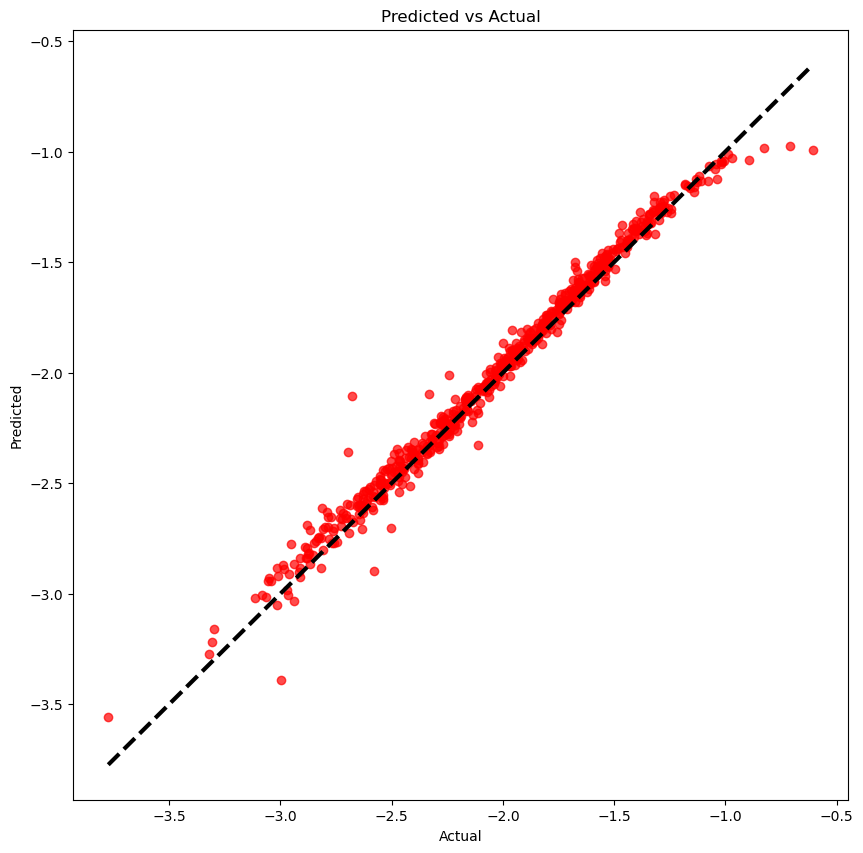

In [21]:
plt.figure(figsize = (10, 10))
plt.scatter(y_test, y_pred, alpha = 0.7, color = 'r')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw = 3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.show()

### 테스트 결과 샘플 시각화

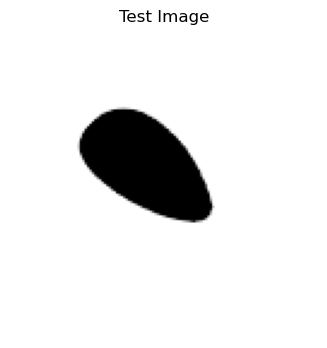

Predicted Drag Coefficient: [-1.819]
Actual Drag Coefficient: [-1.80795]


In [22]:
## test sample index = 0

idx = 0
test_img = X_test[idx:idx + 1]
test_label = y_test[idx]

predict = model.predict(test_img, verbose = 0)
predicted_drag = predict[0][0]

plt.figure(figsize = (9, 4))
plt.imshow(test_img.reshape(128, 128), cmap = 'gray')
plt.axis('off')
plt.title('Test Image')
plt.show()

print(f'Predicted Drag Coefficient: [{predicted_drag:.3f}]')
print(f'Actual Drag Coefficient: {test_label}')

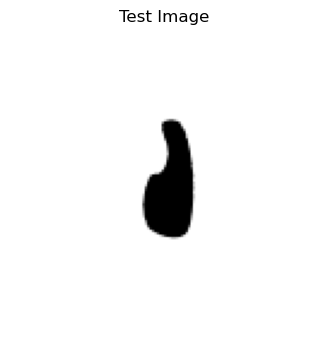

Predicted Drag Coefficient: [-1.797]
Actual Drag Coefficient: [-1.85136]


In [28]:
idx = 410
test_img = X_test[idx:idx + 1]
test_label = y_test[idx]

predict = model.predict(test_img, verbose = 0)
predicted_drag = predict[0][0]

plt.figure(figsize = (9, 4))
plt.imshow(test_img.reshape(128, 128), cmap = 'gray')
plt.axis('off')
plt.title('Test Image')
plt.show()

print(f'Predicted Drag Coefficient: [{predicted_drag:.3f}]')
print(f'Actual Drag Coefficient: {test_label}')

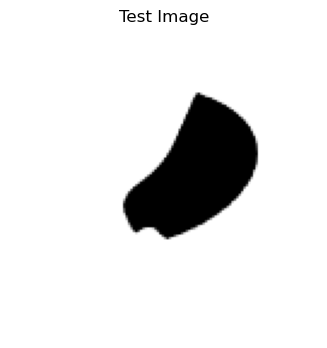

Predicted Drag Coefficient: [-2.140]
Actual Drag Coefficient: [-2.16572]


In [24]:
## test sample index = 0

idx = 300
test_img = X_test[idx:idx + 1]
test_label = y_test[idx]

predict = model.predict(test_img, verbose = 0)
predicted_drag = predict[0][0]

plt.figure(figsize = (9, 4))
plt.imshow(test_img.reshape(128, 128), cmap = 'gray')
plt.axis('off')
plt.title('Test Image')
plt.show()

print(f'Predicted Drag Coefficient: [{predicted_drag:.3f}]')
print(f'Actual Drag Coefficient: {test_label}')